__Aim:__ Consistency analysis across cell lines using pathway enrichment results to find commonly up/down regulated pathways and their genes. 

___
- https://github.com/abearab/ipage-msigdb
- https://github.com/tanghaibao/goatools
- https://gseapy.readthedocs.io/en/latest/index.html

Hani: _"You must redo iPAGE with `--independence=0` option for comparing results between multiple smaples."_

In [1]:
import re
import sys
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from time import time 
from glob import glob
from matplotlib.pyplot import subplots
from itertools import chain
from functools import reduce
from venn import venn

# sys.path.append('/rumi/shams/abe/Projects/ipage-down/')
sys.path.append('/data_gilbert/home/aarab/Projects/ipage-msigdb/')

import upsetplot as us
import ipage_down as ipd
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
from IPython.display import IFrame

In [3]:
dictfilt = lambda x, y: dict([ (i,x[i]) for i in x if i in set(y) ])

In [1]:
cat ../ipage_loop.sh

## $1: input file contain table with first two columns as gene name/id and numeric value
pattern='msigdb*'
# pattern='human_*_gs*'

expfile=`basename $1`
outdir=${1/.txt/};

mkdir -p $outdir
cd $outdir; cd ../

for f in `ls -d $PAGEDIR/PAGE_DATA/ANNOTATIONS/${pattern}`; do

    base=`basename "$f"`;
    echo '________________' $base '________________';

    if [ -d "${outdir}/${base}/" ]; 
    then
        echo 'This result exist!';
    else
        # Run iPAGE 
        perl $PAGEDIR/page.pl --expfile=$expfile --species=$base --exptype=continuous --ebins=11 --nodups=1 --independence=0; 
        # --independence=0; option for comparing results between multiple smaples.
        wait

        mv -v ${expfile}_PAGE/ ${outdir}/${base}/;

        # remove the result folder if it was empty
        counter="$(wc -l < ${outdir}/${base}/pvmatrix.txt)"
        if [ $counter -le "$(echo '1')" ] || [ -z $counter ]
        then
            rm -r ${outdir}/${base}/
        else
            # keep com

In [ ]:
# %%bash
# echo '<h1>'Enrichment analysis'<h1>' >> README.md

# declare -a Comp=('6h' '72h' '120h')

# for f in `ls -d /flash/bin/iPAGEv1.0/PAGE_DATA/ANNOTATIONS/human_ensembl*`; do
#     base=`basename "$f"`
#     echo '<table>' >> README.md
#     echo '  <tr>' >> README.md
#     echo '  <h2>'$base'<h2>' >> README.md
#     for C in "${Comp[@]}"; do
#         echo '    <td><img src='${C}'_delta_exp/'${base}'.all.png style="width:600px">' >> README.md
#     done
#     echo '  <tr>' >> README.md
#     echo '<table>' >> README.md
# done

## $\Delta$Expression

#### `ind0`

In [ ]:
%%bash
export PAGEDIR='/data_gilbert/home/aarab/iPAGE'

cd exp/
ls *_delta_exp.txt | parallel -j18 -k bash ../../ipage_loop.sh
cd ../

In [20]:
!rm -r exp/*delta_exp/*/*.html exp/*delta_exp/*/*.eps exp/*delta_exp/*/imgsrc exp/*delta_exp/*/SUMMARY

In [29]:
%%bash 
for f in  exp/*delta_exp/; do o=${f/delta_exp/delta_exp_ind0}; mv -v $f $o; done 

‘exp/hl60_120h_delta_exp/’ -> ‘exp/hl60_120h_delta_exp_ind0/’
‘exp/hl60_6h_delta_exp/’ -> ‘exp/hl60_6h_delta_exp_ind0/’
‘exp/hl60_72h_delta_exp/’ -> ‘exp/hl60_72h_delta_exp_ind0/’
‘exp/hl60_72h_only_delta_exp/’ -> ‘exp/hl60_72h_only_delta_exp_ind0/’
‘exp/kg1_delta_exp/’ -> ‘exp/kg1_delta_exp_ind0/’
‘exp/molm14_delta_exp/’ -> ‘exp/molm14_delta_exp_ind0/’
‘exp/ociaml2_delta_exp/’ -> ‘exp/ociaml2_delta_exp_ind0/’
‘exp/ociaml3_delta_exp/’ -> ‘exp/ociaml3_delta_exp_ind0/’
‘exp/thp1_delta_exp/’ -> ‘exp/thp1_delta_exp_ind0/’


#### `ind1`

In [ ]:
%%bash
export PAGEDIR='/data_gilbert/home/aarab/iPAGE'

cd exp/
ls *_delta_exp.txt | parallel -j18 -k bash ../../ipage_loop.sh
cd ../

In [77]:
%%bash 
for f in  exp/*_delta_exp/; do o=${f/_delta_exp/_delta_exp_ind1}; mv -v $f $o; done 

‘exp/hl60_120h_delta_exp/’ -> ‘exp/hl60_120h_delta_exp_ind1/’
‘exp/hl60_6h_delta_exp/’ -> ‘exp/hl60_6h_delta_exp_ind1/’
‘exp/hl60_72h_delta_exp/’ -> ‘exp/hl60_72h_delta_exp_ind1/’
‘exp/hl60_72h_only_delta_exp/’ -> ‘exp/hl60_72h_only_delta_exp_ind1/’
‘exp/kg1_delta_exp/’ -> ‘exp/kg1_delta_exp_ind1/’
‘exp/molm14_delta_exp/’ -> ‘exp/molm14_delta_exp_ind1/’
‘exp/ociaml2_delta_exp/’ -> ‘exp/ociaml2_delta_exp_ind1/’
‘exp/ociaml3_delta_exp/’ -> ‘exp/ociaml3_delta_exp_ind1/’
‘exp/thp1_delta_exp/’ -> ‘exp/thp1_delta_exp_ind1/’


### Remake from pvmatrix (correct bin clusters)

In [83]:
# ls -d exp/*_ind1/*

In [25]:
hl60_pws = {}

In [4]:
def read_ipage_intersections_file(gs_cluster_path,clust,gs=None):
    with open(f'{gs_cluster_path}/output.ipage_intersections') as raw:
        lines = [line for line in raw.read().splitlines()]
        if gs: 
            lines = [line.split('\t') for line in lines if re.search(gs, line)]
        else:
            lines = [line.split('\t') for line in lines]

    #     left  = dict([(line[0].split(' ')[0],line[2:]) for line in lines if line[1] == '0' ])
    #     right = dict([(line[0].split(' ')[0],line[2:]) for line in lines if line[1] == '10'])
    # return left,right
    return dict([(line[0].split(' ')[0],line[2:]) for line in lines if line[1] == clust ])


def merge_multiple_pvmat(pvmat_list):
    df = ipd.clean_bins_range(
        ipd.read_pvmatrix(pvmat_list[0])
    )

    cols = df.columns

    df = pd.concat(
        [df] + [
            ipd.read_pvmatrix(pvmat).set_axis(cols, axis=1, inplace=False) 
            for pvmat in pvmat_list[1:]
        ]
    )

    df = df.groupby(df.index).first()
    # ipd.style_clean_pvmatrix(df.iloc[:,[0,10]])    
    return df

In [5]:
def pvmat2bio_signal(pvmat,side,n_clust=2):
    if side == 'up':
        out = pvmat.loc[
            (pd.DataFrame(pvmat.iloc  [:,-n_clust:]  > 2).all(axis=1)) & 
            (pd.DataFrame(pvmat.iloc  [:,:-n_clust]  < 2).all(axis=1))
            ,:
        ].sort_values(by=pvmat.columns[-n_clust:].to_list()[::-1],ascending=False,axis=0)
    elif side == 'both':
        out = pvmat.loc[
            (pd.DataFrame(pvmat.iloc  [:,:n_clust]  > 2).all(axis=1)) & 
            (pd.DataFrame(pvmat.iloc  [:,-n_clust:]  > 2).all(axis=1)) & 
            (pd.DataFrame(pvmat.iloc  [:,n_clust+1:-n_clust]  < 2).all(axis=1))
            ,:
        ].sort_values(
            by=pvmat.columns[-n_clust:].to_list()[::-1] + pvmat.columns[:n_clust].to_list(),
            ascending=False,axis=0
        )
    elif side == 'down':
        out = pvmat.loc[
            (pd.DataFrame(pvmat.iloc  [:,:n_clust]  > 2).all(axis=1)) & 
            (pd.DataFrame(pvmat.iloc  [:,n_clust+1:]  < 2).all(axis=1))
            ,:
        ].sort_values(by=pvmat.columns[:n_clust].to_list(),ascending=False,axis=0)
    return out

In [6]:
def detect_gs_cluster(pvmat_list, gs):
    return [
        pvmat for pvmat in pvmat_list
        if gs in ipd.read_pvmatrix(pvmat).index.to_list()
        
    ]

### HL-60 time series

In [8]:
# hl60_pws ['120h'] = merge_multiple_pvmat(
#     pvmat_list = glob('exp/hl60_120h_delta_exp_ind0/*c5*/pvmatrix.[L-R].txt')
# )

#### hl60 6h delta_exp

In [14]:
study = 'hl60_6h_delta_exp'

pvmat = merge_multiple_pvmat(
    pvmat_list = glob(f'exp/{study}_ind1/*c5.go*/pvmatrix.txt') + glob(f'exp/{study}_ind1/*c2.cp.kegg*/pvmatrix.txt')
)

bio_signal = pd.concat([
    pvmat2bio_signal(pvmat,side='down',n_clust=2),
    # pvmat2bio_signal(pvmat,side='down',n_clust=1),
    # pvmat2bio_signal(pvmat,side='up',n_clust=1),
    pvmat2bio_signal(pvmat,side='up',n_clust=2),
    # pvmat2bio_signal(pvmat,side='both'),
],axis=0)

bio_signal = bio_signal[~bio_signal.index.duplicated()]

bio_signal.to_csv(f'exp/{study}_pvmatrix.txt',sep='\t')

exp_file = f'exp/{study}.txt'
pvmat_file = f'exp/{study}_pvmatrix.txt'

!bash ../ipage_draw_matrix.sh $exp_file $pvmat_file
!rm $pvmat_file

Reading matrix ... Done.
Cluster rows .. best merge is 4, 5, 0.03421678870196
best merge is 3, 4, 0.129338216213538
order classes
2 - 0.05132518305294
4 5
1
2
3
0
Done.Start drawing
0.98	-0.71
GOBP_CHLORIDE_TRANSPORT, 
GOBP_PERIPHERAL_NERVOUS_SYSTEM_DEVELOPMENT, 
GOBP_AMINOGLYCAN_METABOLIC_PROCESS, 
GOCC_INTRINSIC_COMPONENT_OF_POSTSYNAPTIC_MEMBRANE, 
GOBP_DIGESTIVE_SYSTEM_DEVELOPMENT, 
GOBP_TRANSMISSION_OF_NERVE_IMPULSE, 
Outputing EPS file exp/hl60_6h_delta_exp.txt_PAGE/hl60_6h_delta_exp.txt.summary.eps
Convert to PDF exp/hl60_6h_delta_exp.txt_PAGE/hl60_6h_delta_exp.txt.summary.pdf
Finished.
‘exp/hl60_6h_delta_exp.txt_PAGE/hl60_6h_delta_exp.txt.summary.pdf’ -> ‘exp/hl60_6h_delta_exp.pdf’
removed ‘exp/hl60_6h_delta_exp.txt_PAGE/hl60_6h_delta_exp.txt.summary.eps’
removed directory: ‘exp/hl60_6h_delta_exp.txt_PAGE’


In [15]:
pdf = 'exp/hl60_6h_delta_exp.pdf'
IFrame(pdf, width=800, height=600)

In [160]:
# gs_cluster_path = ipd.detect_gs_cluster(pvmat_list, gs=gs)

# print ([p.split('/')[1:3] for p in gs_cluster_path])

# gs_cluster_path = gs_cluster_path[1].split('pvmatrix.R.txt')[0]
# print ('Down')
# print (ipd.bin_identifier_genes(gs_cluster_path, '0', gs=gs))
# print ('Up')
# print (ipd.bin_identifier_genes(gs_cluster_path, '9', gs=gs))
# print (ipd.bin_identifier_genes(gs_cluster_path, '10', gs=gs))

#### hl60 72h delta_exp

In [20]:
study = 'hl60_72h_delta_exp'

pvmat = merge_multiple_pvmat(
    pvmat_list = glob(f'exp/{study}_ind1/*c5.go*/pvmatrix.txt') + glob(f'exp/{study}_ind1/*c2.cp.kegg*/pvmatrix.txt')
)

bio_signal = pd.concat([
    pvmat2bio_signal(pvmat,side='down',n_clust=3),
    pvmat2bio_signal(pvmat,side='down',n_clust=2),
    # pvmat2bio_signal(pvmat,side='down',n_clust=1),
    # pvmat2bio_signal(pvmat,side='up',n_clust=1),
    pvmat2bio_signal(pvmat,side='up',n_clust=2),
    pvmat2bio_signal(pvmat,side='up',n_clust=3),
    # pvmat2bio_signal(pvmat,side='both',n_clust=1),
],axis=0)

bio_signal = bio_signal[~bio_signal.index.duplicated()]

bio_signal.to_csv(f'exp/{study}_pvmatrix.txt',sep='\t')

exp_file = f'exp/{study}.txt'
pvmat_file = f'exp/{study}_pvmatrix.txt'
!bash ../ipage_draw_matrix.sh $exp_file $pvmat_file
# !rm $pvmat_file

Reading matrix ... Done.
Cluster rows .. best merge is 2, 4, 0.0154495366743223
best merge is 5, 6, 0.0291317802345272
best merge is 0, 2, 0.0406459171529002
best merge is 3, 5, 0.0585007151386386
best merge is 0, 1, 0.0646233525096261
best merge is 0, 3, 0.0984190971370287
best merge is 8, 10, 0.116982389929845
best merge is 8, 11, 0.164764752624878
order classes
7 - 0.113197000909515
2 - 0.350947169789534
0 2 4 1 3 5 6
7
8 10
9
11
Done.Start drawing
2.03	-1.17
GOBP_PIRNA_METABOLIC_PROCESS, 
GOBP_INTERLEUKIN_4_PRODUCTION, 
GOBP_ACTIN_FILAMENT_BASED_MOVEMENT, 
GOBP_HOMOPHILIC_CELL_ADHESION_VIA_PLASMA_MEMBRANE_ADHESION_MOLECULES, 
GOBP_MITOCHONDRIAL_TRANSLATION, 
GOBP_TRNA_PROCESSING, 
GOMF_CATALYTIC_ACTIVITY_ACTING_ON_A_TRNA, 
GOMF_STRUCTURAL_CONSTITUENT_OF_RIBOSOME, 
GOBP_MITOCHONDRIAL_RESPIRATORY_CHAIN_COMPLEX_ASSEMBLY, 
GOCC_INNER_MITOCHONDRIAL_MEMBRANE_PROTEIN_COMPLEX, 
GOBP_ALPHA_AMINO_ACID_METABOLIC_PROCESS, 
KEGG_ARGININE_AND_PROLINE_METABOLISM, 
Outputing EPS file exp/hl60_72h_

In [44]:
pdf = 'exp/hl60_72h_delta_exp.pdf'
IFrame(pdf, width=800, height=200)

#### hl60 120h delta_exp

In [22]:
study = 'hl60_120h_delta_exp'

pvmat = merge_multiple_pvmat(
    pvmat_list = glob(f'exp/{study}_ind1/*c5.go*/pvmatrix.txt') + glob(f'exp/{study}_ind1/*c2.cp.kegg*/pvmatrix.txt')
)

bio_signal = pd.concat([
    pvmat2bio_signal(pvmat,side='down',n_clust=3),
    pvmat2bio_signal(pvmat,side='down',n_clust=2),
    # pvmat2bio_signal(pvmat,side='down',n_clust=1),
    # pvmat2bio_signal(pvmat,side='up',n_clust=1),
    pvmat2bio_signal(pvmat,side='up',n_clust=2),
    pvmat2bio_signal(pvmat,side='up',n_clust=3),
    # pvmat2bio_signal(pvmat,side='both',n_clust=1),
],axis=0)

bio_signal = bio_signal[~bio_signal.index.duplicated()]

bio_signal.to_csv(f'exp/{study}_pvmatrix.txt',sep='\t')

exp_file = f'exp/{study}.txt'
pvmat_file = f'exp/{study}_pvmatrix.txt'
!bash ../ipage_draw_matrix.sh $exp_file $pvmat_file
# !rm $pvmat_file

Reading matrix ... Done.
Cluster rows .. best merge is 5, 6, 0.00917815041791425
best merge is 3, 5, 0.0181760435209474
best merge is 11, 12, 0.0181962462735121
best merge is 0, 10, 0.0324345390533211
best merge is 0, 4, 0.0343795188761162
best merge is 7, 8, 0.0359355337914352
best merge is 16, 22, 0.0470305234169472
best merge is 3, 7, 0.057786377262214
best merge is 0, 1, 0.0601330620018032
best merge is 14, 15, 0.0607235067115951
best merge is 16, 23, 0.0733522662824038
best merge is 0, 13, 0.0784701668832188
best merge is 14, 17, 0.0803846407001989
best merge is 0, 11, 0.083293709290138
best merge is 18, 19, 0.101876504609925
best merge is 3, 9, 0.102732765697954
best merge is 25, 26, 0.110681104557474
best merge is 16, 18, 0.117512816398401
best merge is 14, 16, 0.146627520257435
best merge is 14, 20, 0.147884970556992
best merge is 0, 2, 0.173215889844249
best merge is 0, 3, 0.218958775429656
best merge is 14, 21, 0.236170170851606
order classes
14 - 0.277694352204001
9 - 0.3410

In [45]:
pdf = 'exp/hl60_120h_delta_exp.pdf'
IFrame(pdf, width=800, height=300)

In [39]:
pvmat_list = glob(f'exp/{study}_ind1/*c5.go*/pvmatrix.txt')


In [40]:
gs = 'GOBP_REGULATION_OF_CHOLESTEROL_BIOSYNTHETIC_PROCESS'

gs_cluster_path = ipd.detect_gs_cluster(pvmat_list, gs=gs)

print ([p.split('/')[1:3] for p in gs_cluster_path])

gs_cluster_path = gs_cluster_path[0].split('pvmatrix.txt')[0]

print ('Down')
print (list(ipd.bin_identifier_genes(gs_cluster_path, '0', gs=gs).values())+list(ipd.bin_identifier_genes(gs_cluster_path, '1', gs=gs).values()))# print (ipd.bin_identifier_genes(gs_cluster_path, '1', gs=gs))

# print ('Up')
# print (list(ipd.bin_identifier_genes(gs_cluster_path, '9', gs=gs).values())+list(ipd.bin_identifier_genes(gs_cluster_path, '10', gs=gs).values()))

[['hl60_120h_delta_exp_ind1', 'msigdb_v7.4_c5.go'], ['hl60_120h_delta_exp_ind1', 'msigdb_v7.4_c5.go.bp']]
Down
[['SCD', 'SEC14L2', 'HMGCS1', 'ABCG1', 'LSS', 'CYP7A1', 'ELOVL6', 'MIR30C1', 'MIR548P', 'ACACA'], ['CYP51A1', 'FDFT1', 'SQLE', 'ERLIN1', 'KPNB1', 'SC5D', 'HMGCR', 'SCAP', 'GPAM', 'RAN', 'SOD1', 'FDPS', 'PMVK', 'DHCR7']]


In [43]:
gs = 'GOMF_S_ADENOSYLMETHIONINE_DEPENDENT_METHYLTRANSFERASE_ACTIVITY'

gs_cluster_path = ipd.detect_gs_cluster(pvmat_list, gs=gs)

print ([p.split('/')[1:3] for p in gs_cluster_path])

gs_cluster_path = gs_cluster_path[0].split('pvmatrix.txt')[0]

print ('Down')
print (list(ipd.bin_identifier_genes(gs_cluster_path, '0', gs=gs).values())+list(ipd.bin_identifier_genes(gs_cluster_path, '1', gs=gs).values()))# print (ipd.bin_identifier_genes(gs_cluster_path, '1', gs=gs))

# print ('Up')
# print (list(ipd.bin_identifier_genes(gs_cluster_path, '9', gs=gs).values())+list(ipd.bin_identifier_genes(gs_cluster_path, '10', gs=gs).values()))

[['hl60_120h_delta_exp_ind1', 'msigdb_v7.4_c5.go']]
Down
[['METTL1', 'FTSJ1', 'PRMT5', 'SETD6', 'FBL', 'DPH5', 'KMT2A', 'EEF2KMT', 'METTL8', 'PRMT1', 'METTL16', 'COQ3', 'PRMT7', 'PEMT', 'MEN1', 'CARM1', 'SETD7', 'TFB2M', 'TRMT61A', 'SETMAR', 'TRMT61B', 'MRM3', 'TRMT10C', 'PRMT3', 'WDR5'], ['TFB1M', 'NSUN2', 'TARBP1', 'TRMT11', 'BUD23', 'DIMT1', 'METTL2A', 'TRMT6', 'RNMT', 'SUV39H1', 'TRMT1', 'FTSJ3', 'NOP2', 'ICMT', 'NSUN4', 'MRM2', 'EEF1AKMT3', 'EMG1', 'TRMT5', 'DNMT1', 'RRP8', 'SETDB2', 'THUMPD2', 'METTL5', 'PRDM16', 'EEF1AKMT1', 'SUV39H2', 'SETD9', 'CARNMT1', 'WDR4', 'COMTD1', 'ZCCHC4', 'PRMT6', 'EHMT2', 'MRM1', 'EEF1AKMT4']]


#### Intersection 

In [170]:
data = dict([
    ('6h_dn',  set(hl60_pws['6h'  ].loc[hl60_pws['6h'].iloc  [:,0]   > 2,:].index.to_list())),
    ('6h_up',  set(hl60_pws['6h'  ].loc[hl60_pws['6h'].iloc  [:,10]  > 2,:].index.to_list())),
    ('72h_dn', set(hl60_pws['72h' ].loc[hl60_pws['72h'].iloc [:,0]   > 2,:].index.to_list())),
    ('72h_up', set(hl60_pws['72h' ].loc[hl60_pws['72h'].iloc [:,10]  > 2,:].index.to_list())),
    ('120h_dn',set(hl60_pws['120h'].loc[hl60_pws['120h'].iloc[:,0]   > 2,:].index.to_list())),
    ('120h_up',set(hl60_pws['120h'].loc[hl60_pws['120h'].iloc[:,10]  > 2,:].index.to_list())),
])

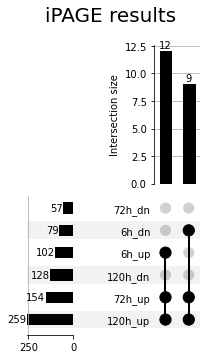

In [171]:
fig1 = plt.figure()
upset1 = us.UpSet(
    us.from_contents(data),
    min_subset_size=5,
    min_degree=3,
    max_degree=3,
    orientation='horizontal',show_counts=True,
)
# upset1.style_subsets(present='hl60_72h_only',edgecolor="red",linewidth=2)
upset1.plot(fig=fig1)
fig1.suptitle('iPAGE results',fontsize=20)
plt.show()
# pdf.savefig()

In [238]:
hl60_intersect = data['6h_dn'].intersection(data['72h_up']).intersection(data['120h_up'])

In [281]:
hl60_intersect_genes = {}
for gs in hl60_intersect:
    genes = {}
    genes['6h'] = read_ipage_intersections_file(
            detect_gs_cluster(
                pvmat_list = glob(f'exp/hl60_6h_delta_exp_ind0/*c5*/pvmatrix.L.txt'),
                gs = gs,
            )[0].split('pvmatrix')[0],gs = gs,clust = '0',
        
        )
    
    genes['72h'] = read_ipage_intersections_file(
            detect_gs_cluster(
                pvmat_list = glob(f'exp/hl60_72h_delta_exp_ind0/*c5*/pvmatrix.R.txt'),
                gs = gs
            )[0].split('pvmatrix')[0],gs = gs,clust = '10',
        )

    genes['120h'] = read_ipage_intersections_file(
            detect_gs_cluster(
                pvmat_list = glob(f'exp/hl60_120h_delta_exp_ind0/*c5*/pvmatrix.R.txt'),
                gs = gs
            )[0].split('pvmatrix')[0],gs = gs,clust = '10',
        )
    hl60_intersect_genes[gs] = set(genes['6h'][gs]).intersection(
            set(genes['72h'][gs])).intersection(set(genes['120h'][gs]))

In [285]:
hl60_intersect_genes#.values()

{'GOCC_INTRINSIC_COMPONENT_OF_SYNAPTIC_MEMBRANE': {'GRIK5', 'KCND2'},
 'GOBP_REGULATION_OF_HEART_RATE_BY_CARDIAC_CONDUCTION': set(),
 'GOBP_ACTION_POTENTIAL': {'KCND2', 'NEDD4L'},
 'GOBP_DNA_METHYLATION_INVOLVED_IN_GAMETE_GENERATION': {'MAEL',
  'PIWIL2',
  'TDRD1'},
 'GOMF_VOLTAGE_GATED_CATION_CHANNEL_ACTIVITY': {'GRIN3A', 'KCND2', 'KCNQ3'},
 'GOBP_CARDIAC_MUSCLE_CELL_ACTION_POTENTIAL_INVOLVED_IN_CONTRACTION': {'NEDD4L'},
 'GOBP_STRIATED_MUSCLE_CONTRACTION': {'MYBPC3', 'NEDD4L'},
 'GOMF_VOLTAGE_GATED_ION_CHANNEL_ACTIVITY': {'GRIN3A', 'KCND2', 'KCNQ3'},
 'GOMF_LIGAND_GATED_ION_CHANNEL_ACTIVITY': {'GRIK5', 'GRIN3A'},
 'GOBP_HOMOPHILIC_CELL_ADHESION_VIA_PLASMA_MEMBRANE_ADHESION_MOLECULES': {'AMIGO2',
  'CDHR5',
  'DSC1',
  'PCDHA5'},
 'GOBP_VENTRICULAR_CARDIAC_MUSCLE_CELL_ACTION_POTENTIAL': {'NEDD4L'},
 'GOBP_ACTIN_MEDIATED_CELL_CONTRACTION': {'MYBPC3', 'NEDD4L'},
 'GOCC_INTRINSIC_COMPONENT_OF_POSTSYNAPTIC_MEMBRANE': {'GRIK5', 'KCND2'},
 'GOBP_SYNAPSE_ASSEMBLY': {'AMIGO2', 'LRTM2', 'NRCA

In [147]:
# plt.figure(figsize=(8,8))

# # Make venn diagram                                                                                                                                                             
# v = venn3_unweighted(
#     [Exp_down,Rho_down,Hyper_m6A],('ΔRNA Expression\nlog2FC < -0.1','ΔPhenotype (ρ)\nlog2FC < -0.1','ΔRNA Methylation\nlog2FC > 1')
#     ,normalize_to=0.5
# )

# for x in ['100','010','001','110','101','011']:
#     v.get_patch_by_id(x).set_alpha(0.5)
#     v.get_patch_by_id(x).set_color('lightgrey')
#     v.get_label_by_id(x).set_fontsize(12)

# v.get_patch_by_id('111').set_color('y')
# v.get_label_by_id('111').set_fontsize(15)


# c = venn3_circles(
#     (1,1,1,1,1,1,1), linestyle='dashed'
#     ,normalize_to=0.5
# )
# for i,_ in enumerate(c):
#     c[i].set_lw(1.0)
#     c[i].set_ls('dotted')

# plt.title("Intersectional genes", fontsize=20)
# plt.annotate(
#     venn_genes_label, xy=v.get_label_by_id('111').get_position() - np.array([0, 0.05]), 
#     xytext=(-180,-250),
#     ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
#     fontsize=12, 
#     arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray')
# )

# plt.figtext(
#     0.5, 0.08, "pvalue < 0.05", ha="center", fontsize=10, 
#     bbox={"facecolor":"lightgray", "alpha":0.1, "pad":5}
# )

# plt.savefig('intersectional-genes/venn_plot_Exp_down_Rho_down_Hyper_m6A.pdf')
# plt.show()

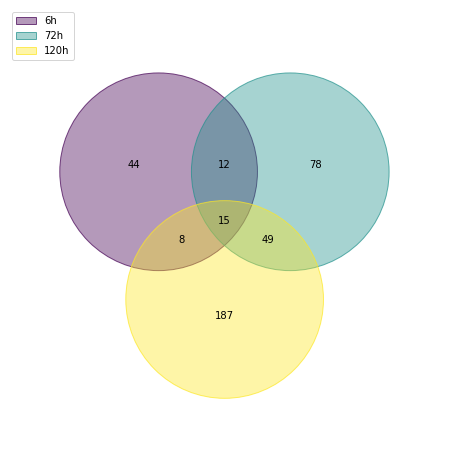

In [135]:
venn(
    data,fontsize=10,legend_loc="upper left"
)
plt.show()

### 

#### hl60_6h_delta_exp_ind1

In [76]:
ind1 = 'exp/hl60_6h_delta_exp_ind1'
df = ipd.clean_bins_range(
    pd.concat([
        ipd.read_pvmatrix(f'{ind1}/msigdb_v7.4_c5.all/pvmatrix.L.txt'),
        ipd.read_pvmatrix(f'{ind1}/msigdb_v7.4_c5.all/pvmatrix.R.txt')
    ])
)

df = df.groupby(df.index).first()

df.index = [f'{x} {x}' for x in df.index]

df.to_csv(f"{ind1.replace('_ind1','_pvmatrix')}.txt",sep = '\t')

In [78]:
hl60_pws ['6h'] = df

#### hl60_72h_delta_exp_ind1

In [79]:
ind1 = 'exp/hl60_72h_delta_exp_ind1'
df = ipd.clean_bins_range(
    pd.concat([
        ipd.read_pvmatrix(f'{ind1}/msigdb_v7.4_c5.all/pvmatrix.L.txt'),
        ipd.read_pvmatrix(f'{ind1}/msigdb_v7.4_c5.all/pvmatrix.R.txt')
    ])
)

df = df.groupby(df.index).first()

df.index = [f'{x} {x}' for x in df.index]

df.to_csv(f"{ind1.replace('_ind1','_pvmatrix')}.txt",sep = '\t')

In [80]:
hl60_pws ['72h'] = df

#### hl60_120h_delta_exp_ind1   

In [81]:
ind1 = 'exp/hl60_120h_delta_exp_ind1'
df = ipd.clean_bins_range(
    pd.concat([
        ipd.read_pvmatrix(f'{ind1}/msigdb_v7.4_c5.all/pvmatrix.L.txt'),
        ipd.read_pvmatrix(f'{ind1}/msigdb_v7.4_c5.all/pvmatrix.R.txt')
    ])
)

df = df.groupby(df.index).first()

df.index = [f'{x} {x}' for x in df.index]

df.to_csv(f"{ind1.replace('_ind1','_pvmatrix')}.txt",sep = '\t')

In [82]:
hl60_pws ['120h'] = df

### 72h trearment in all cell lines 

#### hl60_72h_only_delta_exp_ind1

In [50]:
ind1 = 'exp/hl60_72h_only_delta_exp_ind1'
df = ipd.clean_bins_range(
    pd.concat([
        ipd.read_pvmatrix(f'{ind1}/msigdb_v7.4_c5.all/pvmatrix.L.txt'),
        ipd.read_pvmatrix(f'{ind1}/msigdb_v7.4_c5.all/pvmatrix.R.txt')
    ])
)

df = df.groupby(df.index).first()

df.index = [f'{x} {x}' for x in df.index]

df.to_csv(f"{ind1.replace('_ind1','_pvmatrix')}.txt",sep = '\t')

#### molm14_delta_exp_ind1

In [51]:
ind1 = 'exp/molm14_delta_exp_ind1'
df = ipd.clean_bins_range(
    pd.concat([
        ipd.read_pvmatrix(f'{ind1}/msigdb_v7.4_c5.all/pvmatrix.L.txt'),
        ipd.read_pvmatrix(f'{ind1}/msigdb_v7.4_c5.all/pvmatrix.R.txt')
    ])
)

df = df.groupby(df.index).first()

df.index = [f'{x} {x}' for x in df.index]

df.to_csv(f"{ind1.replace('_ind1','_pvmatrix')}.txt",sep = '\t')

#### ociaml2_delta_exp_ind1

In [52]:
ind1 = 'exp/ociaml2_delta_exp_ind1'
df = ipd.clean_bins_range(
    pd.concat([
        ipd.read_pvmatrix(f'{ind1}/msigdb_v7.4_c5.all/pvmatrix.L.txt'),
        ipd.read_pvmatrix(f'{ind1}/msigdb_v7.4_c5.all/pvmatrix.R.txt')
    ])
)

df = df.groupby(df.index).first()

df.index = [f'{x} {x}' for x in df.index]

df.to_csv(f"{ind1.replace('_ind1','_pvmatrix')}.txt",sep = '\t')

#### ociaml3_delta_exp_ind1

In [53]:
ind1 = 'exp/ociaml3_delta_exp_ind1'
df = ipd.clean_bins_range(
    pd.concat([
        ipd.read_pvmatrix(f'{ind1}/msigdb_v7.4_c5.all/pvmatrix.L.txt'),
        ipd.read_pvmatrix(f'{ind1}/msigdb_v7.4_c5.all/pvmatrix.R.txt')
    ])
)

df = df.groupby(df.index).first()

df.index = [f'{x} {x}' for x in df.index]

df.to_csv(f"{ind1.replace('_ind1','_pvmatrix')}.txt",sep = '\t')

#### thp1_delta_exp_ind1

In [54]:
ind1 = 'exp/thp1_delta_exp_ind1'
df = ipd.clean_bins_range(
    pd.concat([
        ipd.read_pvmatrix(f'{ind1}/msigdb_v7.4_c5.all/pvmatrix.L.txt'),
        ipd.read_pvmatrix(f'{ind1}/msigdb_v7.4_c5.all/pvmatrix.R.txt')
    ])
)

df = df.groupby(df.index).first()

df.index = [f'{x} {x}' for x in df.index]

df.to_csv(f"{ind1.replace('_ind1','_pvmatrix')}.txt",sep = '\t')

#### kg1_delta_exp_ind1

In [55]:
ind1 = 'exp/kg1_delta_exp_ind1'
df = ipd.clean_bins_range(
    pd.concat([
        ipd.read_pvmatrix(f'{ind1}/msigdb_v7.4_c5.all/pvmatrix.L.txt'),
        ipd.read_pvmatrix(f'{ind1}/msigdb_v7.4_c5.all/pvmatrix.R.txt')
    ])
)

df = df.groupby(df.index).first()

df.index = [f'{x} {x}' for x in df.index]

df.to_csv(f"{ind1.replace('_ind1','_pvmatrix')}.txt",sep = '\t')

### 
___

In [61]:
%%bash 
cd exp
for exp in *delta_exp.txt; do 
    pv=${exp/.txt/_pvmatrix.txt};
    bash ../../ipage_draw_matrix.sh $exp $pv;
done
cd ../

Reading matrix ... Done.
Cluster rows .. best merge is 18, 19, 0.0352146253990937
best merge is 5, 8, 0.0458137702468012
best merge is 0, 13, 0.0558637106600443
best merge is 7, 14, 0.0598616994999702
best merge is 18, 25, 0.0756444324195134
best merge is 20, 24, 0.0788211073661067
best merge is 7, 10, 0.0803175253761167
best merge is 1, 18, 0.08118191202991
best merge is 0, 15, 0.0837272666153618
best merge is 3, 5, 0.110381874673303
best merge is 0, 12, 0.113902662707769
best merge is 2, 20, 0.11652188453818
best merge is 1, 11, 0.12041623580258
best merge is 4, 22, 0.157927385643219
best merge is 2, 3, 0.167740169991511
best merge is 7, 23, 0.198855049062808
best merge is 1, 17, 0.204377890752968
best merge is 1, 2, 0.247425358426626
best merge is 0, 7, 0.276461783106941
best merge is 1, 6, 0.377966993446105
best merge is 1, 4, 0.396517540331822
best merge is 0, 9, 0.477026031668401
order classes
8 - 0.589618723196522
15 - 0.430359824008514
1 18 19 25 11 17 2 20 24 3 5 8 6 4 22
0 13

In [62]:
!rm exp/*_pvmatrix.txt

## $\Delta$Stability

#### `ind0`

In [ ]:
%%bash
export PAGEDIR='/data_gilbert/home/aarab/iPAGE'

cd stbl/
ls *_delta_stbl.txt | parallel -j18 -k bash ../../ipage_loop.sh
cd ../

In [21]:
!rm -r stbl/*delta_stbl/*/*.html stbl/*delta_stbl/*/*.eps stbl/*delta_stbl/*/imgsrc stbl/*delta_stbl/*/SUMMARY

In [30]:
%%bash 
for f in  stbl/*delta_stbl/; do o=${f/delta_stbl/delta_stbl_ind0}; mv -v $f $o; done 

‘stbl/hl60_120h_delta_stbl/’ -> ‘stbl/hl60_120h_delta_stbl_ind0/’
‘stbl/hl60_6h_delta_stbl/’ -> ‘stbl/hl60_6h_delta_stbl_ind0/’
‘stbl/hl60_72h_delta_stbl/’ -> ‘stbl/hl60_72h_delta_stbl_ind0/’
‘stbl/kg1_delta_stbl/’ -> ‘stbl/kg1_delta_stbl_ind0/’
‘stbl/molm14_delta_stbl/’ -> ‘stbl/molm14_delta_stbl_ind0/’
‘stbl/ociaml2_delta_stbl/’ -> ‘stbl/ociaml2_delta_stbl_ind0/’
‘stbl/ociaml3_delta_stbl/’ -> ‘stbl/ociaml3_delta_stbl_ind0/’
‘stbl/thp1_delta_stbl/’ -> ‘stbl/thp1_delta_stbl_ind0/’


#### `ind1`

In [ ]:
%%bash
export PAGEDIR='/data_gilbert/home/aarab/iPAGE'

cd stbl/
ls *_delta_stbl.txt | parallel -j18 -k bash ../../ipage_loop.sh
cd ../

In [31]:
!rm -r stbl/*delta_stbl/*/*.html stbl/*delta_stbl/*/*.eps stbl/*delta_stbl/*/imgsrc stbl/*delta_stbl/*/SUMMARY

In [32]:
%%bash 
for f in  stbl/*delta_stbl/; do o=${f/delta_stbl/delta_stbl_ind1}; mv -v $f $o; done 

‘stbl/hl60_120h_delta_stbl/’ -> ‘stbl/hl60_120h_delta_stbl_ind1/’
‘stbl/hl60_6h_delta_stbl/’ -> ‘stbl/hl60_6h_delta_stbl_ind1/’
‘stbl/hl60_72h_delta_stbl/’ -> ‘stbl/hl60_72h_delta_stbl_ind1/’
‘stbl/kg1_delta_stbl/’ -> ‘stbl/kg1_delta_stbl_ind1/’
‘stbl/molm14_delta_stbl/’ -> ‘stbl/molm14_delta_stbl_ind1/’
‘stbl/ociaml2_delta_stbl/’ -> ‘stbl/ociaml2_delta_stbl_ind1/’
‘stbl/ociaml3_delta_stbl/’ -> ‘stbl/ociaml3_delta_stbl_ind1/’
‘stbl/thp1_delta_stbl/’ -> ‘stbl/thp1_delta_stbl_ind1/’


### Remake from pvmatrix (correct bin clusters)

### HL-60 time series

In [218]:
# hl60_pws ['120h'] = merge_multiple_pvmat(
#     pvmat_list = glob('exp/hl60_120h_delta_exp_ind0/*c5*/pvmatrix.[L-R].txt')
# )

#### hl60 6h delta_stbl

In [98]:
study = 'hl60_6h_delta_stbl'

pvmat = merge_multiple_pvmat(
    pvmat_list = glob(f'stbl/{study}_ind1/*c5.go*/pvmatrix.txt') + glob(f'stbl/{study}_ind1/*c2.cp.kegg*/pvmatrix.txt')
)

bio_signal = pd.concat([
    pvmat2bio_signal(pvmat,side='down',n_clust=1),
    pvmat2bio_signal(pvmat,side='up',n_clust=1),
    # pvmat2bio_signal(pvmat,side='both'),
],axis=0)
bio_signal.to_csv(f'stbl/{study}_pvmatrix.txt',sep='\t')

exp_file = f'stbl/{study}.txt'
pvmat_file = f'stbl/{study}_pvmatrix.txt'
!bash ../ipage_draw_matrix.sh $exp_file $pvmat_file
# !rm $pvmat_file

Reading matrix ... Done.
Start drawing
0.22	-0.22
GOBP_STEROL_BIOSYNTHETIC_PROCESS, 
Outputing EPS file stbl/hl60_6h_delta_stbl.txt_PAGE/hl60_6h_delta_stbl.txt.summary.eps
Convert to PDF stbl/hl60_6h_delta_stbl.txt_PAGE/hl60_6h_delta_stbl.txt.summary.pdf
Finished.
‘stbl/hl60_6h_delta_stbl.txt_PAGE/hl60_6h_delta_stbl.txt.summary.pdf’ -> ‘stbl/hl60_6h_delta_stbl.pdf’
removed ‘stbl/hl60_6h_delta_stbl.txt_PAGE/hl60_6h_delta_stbl.txt.summary.eps’
removed directory: ‘stbl/hl60_6h_delta_stbl.txt_PAGE’


In [99]:
pdf = 'stbl/hl60_6h_delta_stbl.pdf'
IFrame(pdf, width=800, height=200)

In [295]:
gs = 'GOBP_REGULATION_OF_CHOLESTEROL_BIOSYNTHETIC_PROCESS'
pvmat_list = glob(f'stbl/{study}_ind0/*c5.go*/pvmatrix.txt')
gs_cluster_path = ipd.detect_gs_cluster(pvmat_list, gs=gs)

print ([p.split('/')[1:3] for p in gs_cluster_path])

gs_cluster_path = gs_cluster_path[1].split('pvmatrix.txt')[0]
print ('Down')
print (ipd.bin_identifier_genes(gs_cluster_path, '0', gs=gs))
print ('Up')
print (ipd.bin_identifier_genes(gs_cluster_path, '9', gs=gs))
print (ipd.bin_identifier_genes(gs_cluster_path, '10', gs=gs))

[['hl60_6h_delta_stbl_ind0', 'msigdb_v7.4_c5.go'], ['hl60_6h_delta_stbl_ind0', 'msigdb_v7.4_c5.go.bp']]
Down
{'GOBP_REGULATION_OF_CHOLESTEROL_BIOSYNTHETIC_PROCESS': []}
Up
{'GOBP_REGULATION_OF_CHOLESTEROL_BIOSYNTHETIC_PROCESS': ['NFYA', 'SQLE', 'FDPS']}
{'GOBP_REGULATION_OF_CHOLESTEROL_BIOSYNTHETIC_PROCESS': ['SREBF1', 'FDFT1', 'SCAP', 'PRKAA1', 'ERLIN2', 'FASN', 'SREBF2']}


#### hl60 72h delta_stbl

In [105]:
study = 'hl60_72h_delta_stbl'

pvmat = merge_multiple_pvmat(
    pvmat_list = glob(f'stbl/{study}_ind1/*c5.go*/pvmatrix.txt') + glob(f'stbl/{study}_ind1/*c2.cp.kegg*/pvmatrix.txt')
)

bio_signal = pd.concat([
    pvmat2bio_signal(pvmat,side='down',n_clust=1),
    pvmat2bio_signal(pvmat,side='down',n_clust=2),
    pvmat2bio_signal(pvmat,side='up',n_clust=2),
    pvmat2bio_signal(pvmat,side='up',n_clust=1),
    pvmat2bio_signal(pvmat,side='both'),
],axis=0)
bio_signal.to_csv(f'stbl/{study}_pvmatrix.txt',sep='\t')

exp_file = f'stbl/{study}.txt'
pvmat_file = f'stbl/{study}_pvmatrix.txt'
!bash ../ipage_draw_matrix.sh $exp_file $pvmat_file
# !rm $pvmat_file

Reading matrix ... Done.
Cluster rows .. best merge is 0, 2, 0.404334456714884
order classes
0
1
2
Done.Start drawing
0.41	-0.44
GOBP_POSITIVE_REGULATION_OF_CHROMOSOME_ORGANIZATION, 
GOCC_CATALYTIC_STEP_2_SPLICEOSOME, 
GOBP_NUCLEOSOME_ORGANIZATION, 
Outputing EPS file stbl/hl60_72h_delta_stbl.txt_PAGE/hl60_72h_delta_stbl.txt.summary.eps
Convert to PDF stbl/hl60_72h_delta_stbl.txt_PAGE/hl60_72h_delta_stbl.txt.summary.pdf
Finished.
‘stbl/hl60_72h_delta_stbl.txt_PAGE/hl60_72h_delta_stbl.txt.summary.pdf’ -> ‘stbl/hl60_72h_delta_stbl.pdf’
removed ‘stbl/hl60_72h_delta_stbl.txt_PAGE/hl60_72h_delta_stbl.txt.summary.eps’
removed directory: ‘stbl/hl60_72h_delta_stbl.txt_PAGE’


In [106]:
pdf = 'stbl/hl60_72h_delta_stbl.pdf'
IFrame(pdf, width=800, height=200)

In [104]:
gs = 'GOCC_CATALYTIC_STEP_2_SPLICEOSOME'
pvmat_list = glob(f'stbl/{study}_ind0/*c5.go*/pvmatrix.txt')
gs_cluster_path = ipd.detect_gs_cluster(pvmat_list, gs=gs)

print ([p.split('/')[1:3] for p in gs_cluster_path])

gs_cluster_path = gs_cluster_path[1].split('pvmatrix.txt')[0]
print ('Down')
print (ipd.bin_identifier_genes(gs_cluster_path, '0', gs=gs))
print ('Up')
print (ipd.bin_identifier_genes(gs_cluster_path, '9', gs=gs))
print (ipd.bin_identifier_genes(gs_cluster_path, '10', gs=gs))

[['hl60_72h_delta_stbl_ind0', 'msigdb_v7.4_c5.go'], ['hl60_72h_delta_stbl_ind0', 'msigdb_v7.4_c5.go.cc']]
Down
{'GOCC_CATALYTIC_STEP_2_SPLICEOSOME': []}
Up
{'GOCC_CATALYTIC_STEP_2_SPLICEOSOME': ['SNW1', 'SF3B1']}
{'GOCC_CATALYTIC_STEP_2_SPLICEOSOME': ['PABPC1', 'CDC5L', 'HNRNPM', 'PRPF4B', 'HNRNPA2B1', 'HNRNPR', 'SNRPN', 'SRRM1', 'SNRNP200', 'RBMX', 'HNRNPA3']}


#### hl60 120h delta_stbl

In [108]:
study = 'hl60_120h_delta_stbl'

pvmat = merge_multiple_pvmat(
    pvmat_list = glob(f'stbl/{study}_ind1/*c5.go*/pvmatrix.txt') + glob(f'stbl/{study}_ind1/*c2.cp.kegg*/pvmatrix.txt')
)

bio_signal = pd.concat([
    pvmat2bio_signal(pvmat,side='down',n_clust=1),
    pvmat2bio_signal(pvmat,side='down',n_clust=2),
    pvmat2bio_signal(pvmat,side='up',n_clust=2),
    pvmat2bio_signal(pvmat,side='up',n_clust=1),
    pvmat2bio_signal(pvmat,side='both'),
],axis=0)
bio_signal.to_csv(f'stbl/{study}_pvmatrix.txt',sep='\t')

exp_file = f'stbl/{study}.txt'
pvmat_file = f'stbl/{study}_pvmatrix.txt'
!bash ../ipage_draw_matrix.sh $exp_file $pvmat_file
# !rm $pvmat_file

Reading matrix ... Done.
Cluster rows .. best merge is 0, 1, 0
order classes
0
1
2
3
Done.Start drawing
0.4	-0.44
GOBP_RESPONSE_TO_STEROL, 
GOMF_TRANSMEMBRANE_RECEPTOR_PROTEIN_KINASE_ACTIVITY, 
GOBP_POSITIVE_REGULATION_OF_WNT_SIGNALING_PATHWAY, 
GOBP_POSITIVE_REGULATION_OF_WNT_SIGNALING_PATHWAY, 
Outputing EPS file stbl/hl60_120h_delta_stbl.txt_PAGE/hl60_120h_delta_stbl.txt.summary.eps
Convert to PDF stbl/hl60_120h_delta_stbl.txt_PAGE/hl60_120h_delta_stbl.txt.summary.pdf
Finished.
‘stbl/hl60_120h_delta_stbl.txt_PAGE/hl60_120h_delta_stbl.txt.summary.pdf’ -> ‘stbl/hl60_120h_delta_stbl.pdf’
removed ‘stbl/hl60_120h_delta_stbl.txt_PAGE/hl60_120h_delta_stbl.txt.summary.eps’
removed directory: ‘stbl/hl60_120h_delta_stbl.txt_PAGE’


In [109]:
pdf = 'stbl/hl60_120h_delta_stbl.pdf'
IFrame(pdf, width=800, height=200)

In [303]:
gs = 'GOBP_RESPONSE_TO_STEROL'
pvmat_list = glob(f'stbl/{study}_ind0/*c5.go*/pvmatrix.txt')
gs_cluster_path = ipd.detect_gs_cluster(pvmat_list, gs=gs)

print ([p.split('/')[1:3] for p in gs_cluster_path])

gs_cluster_path = gs_cluster_path[1].split('pvmatrix.txt')[0]
print ('Down')
print (ipd.bin_identifier_genes(gs_cluster_path, '0', gs=gs))
print ('Up')
print (ipd.bin_identifier_genes(gs_cluster_path, '9', gs=gs))
print (ipd.bin_identifier_genes(gs_cluster_path, '10', gs=gs))

[['hl60_120h_delta_stbl_ind0', 'msigdb_v7.4_c5.go'], ['hl60_120h_delta_stbl_ind0', 'msigdb_v7.4_c5.go.bp']]
Down
{'GOBP_RESPONSE_TO_STEROL': []}
Up
{'GOBP_RESPONSE_TO_STEROL': ['TGFBR2']}
{'GOBP_RESPONSE_TO_STEROL': ['GRAMD1B', 'TGFBR1', 'LRP8', 'SMAD2', 'CES1']}


In [302]:
# ind1 = 'hl60_120h_delta_stbl_ind1'
# ipd.clean_bins_range(
#     pd.concat([
#         ipd.read_pvmatrix(f'stbl/{ind1}/msigdb_v7.4_c5.all/pvmatrix.L.txt'),
#         ipd.read_pvmatrix(f'stbl/{ind1}/msigdb_v7.4_c5.all/pvmatrix.R.txt')
#     ])
# ).drop_duplicates().to_csv(f"stbl/{ind1.replace('_ind1','_pvmatrix')}.txt",sep = '\t')

#### molm14_delta_stbl_ind1

In [26]:
ind1 = 'molm14_delta_stbl_ind1'
ipd.clean_bins_range(
    pd.concat([
        ipd.read_pvmatrix(f'stbl/{ind1}/msigdb_v7.4_c5.all/pvmatrix.L.txt'),
        ipd.read_pvmatrix(f'stbl/{ind1}/msigdb_v7.4_c5.all/pvmatrix.R.txt')
    ])
).drop_duplicates().to_csv(f"stbl/{ind1.replace('_ind1','_pvmatrix')}.txt",sep = '\t')

#### ociaml2_delta_stbl_ind1

In [27]:
ind1 = 'ociaml2_delta_stbl_ind1'
ipd.clean_bins_range(
    pd.concat([
        ipd.read_pvmatrix(f'stbl/{ind1}/msigdb_v7.4_c5.all/pvmatrix.L.txt'),
        ipd.read_pvmatrix(f'stbl/{ind1}/msigdb_v7.4_c5.all/pvmatrix.R.txt')
    ])
).drop_duplicates().to_csv(f"stbl/{ind1.replace('_ind1','_pvmatrix')}.txt",sep = '\t')

#### ociaml3_delta_stbl_ind1

In [28]:
ind1 = 'ociaml3_delta_stbl_ind1'
ipd.clean_bins_range(
    pd.concat([
        ipd.read_pvmatrix(f'stbl/{ind1}/msigdb_v7.4_c5.all/pvmatrix.L.txt'),
        ipd.read_pvmatrix(f'stbl/{ind1}/msigdb_v7.4_c5.all/pvmatrix.R.txt')
    ])
).drop_duplicates().to_csv(f"stbl/{ind1.replace('_ind1','_pvmatrix')}.txt",sep = '\t')

#### kg1_delta_stbl_ind1

In [29]:
ind1 = 'kg1_delta_stbl_ind1'
ipd.clean_bins_range(
    pd.concat([
        ipd.read_pvmatrix(f'stbl/{ind1}/msigdb_v7.4_c5.all/pvmatrix.L.txt'),
        ipd.read_pvmatrix(f'stbl/{ind1}/msigdb_v7.4_c5.all/pvmatrix.R.txt')
    ])
).drop_duplicates().to_csv(f"stbl/{ind1.replace('_ind1','_pvmatrix')}.txt",sep = '\t')

#### thp1_delta_stbl_ind1

In [30]:
ind1 = 'thp1_delta_stbl_ind1'
ipd.clean_bins_range(
    pd.concat([
        ipd.read_pvmatrix(f'stbl/{ind1}/msigdb_v7.4_c5.all/pvmatrix.L.txt'),
        ipd.read_pvmatrix(f'stbl/{ind1}/msigdb_v7.4_c5.all/pvmatrix.R.txt')
    ])
).drop_duplicates().to_csv(f"stbl/{ind1.replace('_ind1','_pvmatrix')}.txt",sep = '\t')

___

In [31]:
%%bash 
cd stbl
for exp in *delta_stbl.txt; do 
    pv=${exp/.txt/_pvmatrix.txt};
    bash ../../ipage_draw_matrix.sh $exp $pv;
done
cd ../

Reading matrix ... Done.
Cluster rows .. best merge is 1, 3, 0.413997434319903
order classes
0
1
2
3
Done.Start drawing
0.4	-0.44
GOBP_RESPONSE_TO_STEROL, 
GOBP_RECEPTOR_SIGNALING_PATHWAY_VIA_STAT, 
GOBP_REGULATION_OF_MITOCHONDRION_ORGANIZATION, 
GOBP_POSITIVE_REGULATION_OF_WNT_SIGNALING_PATHWAY, 
Outputing EPS file hl60_120h_delta_stbl.txt_PAGE/hl60_120h_delta_stbl.txt.summary.eps
Convert to PDF hl60_120h_delta_stbl.txt_PAGE/hl60_120h_delta_stbl.txt.summary.pdf
Finished.
‘hl60_120h_delta_stbl.txt_PAGE/hl60_120h_delta_stbl.txt.summary.pdf’ -> ‘hl60_120h_delta_stbl.pdf’
removed ‘hl60_120h_delta_stbl.txt_PAGE/hl60_120h_delta_stbl.txt.summary.eps’
removed directory: ‘hl60_120h_delta_stbl.txt_PAGE’
Reading matrix ... Done.
Start drawing
0.22	-0.22
GOBP_STEROL_BIOSYNTHETIC_PROCESS, 
HP_HIGHLY_ARCHED_EYEBROW, 
Outputing EPS file hl60_6h_delta_stbl.txt_PAGE/hl60_6h_delta_stbl.txt.summary.eps
Convert to PDF hl60_6h_delta_stbl.txt_PAGE/hl60_6h_delta_stbl.txt.summary.pdf
Finished.
‘hl60_6h_delta

## Load iPAGE results - iPAGE-down

In [ ]:
import upsetplot as us

from matplotlib.backends.backend_pdf import PdfPages

In [156]:
def read_ipage_intersections_file(gs_cluster_path,gs=None):
    with open(f'{gs_cluster_path}/output.ipage_intersections') as raw:
        lines = [line for line in raw.read().splitlines()]
        if gs: 
            lines = [line.split('\t') for line in lines if re.search(gs, line)][1:]
        else:
            lines = [line.split('\t') for line in lines][1:]

        left  = dict([(line[0].split(' ')[0],line[2:]) for line in lines if line[1] == '0' ])
        right = dict([(line[0].split(' ')[0],line[2:]) for line in lines if line[1] == '10'])

    return left,right

In [450]:
def make_empty_genes_dict(pws,data):
    genes = dict.fromkeys(pws)
    for k in genes:
        genes[k]=dict.fromkeys(data)
        for j in genes[k]: genes[k][j]= {}
    return genes

### $\Delta$Expression

In [121]:
data = dict(
    [(exp.split('/')[1].replace('_delta_exp_ind0',''),ipd.make_ipage_run_data_frame(exp)) for exp in glob('exp/*delta_exp_ind0/')]
)

In [122]:
hl60_data = dict([(time,data[time]) for time in ['hl60_120h','hl60_72h','hl60_6h']])

In [118]:
# del data['hl60_120h']
# del data['hl60_72h']
# del data['hl60_6h']

# Exp_up = dict([(
#     line,
#     # to make it unique pathway accross different msigdb clusters
#     # list(dict(
#         data[line][data[line].iloc[:,10] > 2].sort_index(level='gs_cluster').index.tolist()
# # )
#     # .items()
#     # )
# ) for line in data])

# Exp_dn = dict([(
#     line,
#     # to make it unique pathway accross different msigdb clusters
#     # list(dict(data[line].index[data[line].iloc[:,0] > 2].tolist()).items())
#     data[line][data[line].iloc[:,0] > 2].sort_index(level='gs_cluster').index.tolist()
    
# ) for line in data])

In [420]:
# fig, ((ax1,ax2,ax3,ax4)) = subplots(ncols=2, nrows=1, figsize=(20, 10),dpi=300)

# for std,ax in zip(['Exp_dn', 'Exp_up', 'Stbl_dn', 'Stbl_up'],[ax1,ax2,ax3,ax4]):
#     venn(eval(std),fontsize=6,
# #          legend_loc=None,  
#          legend_loc="lower left",  
#          ax=ax)
#     ax.set_title(std,fontsize=15)

# fig.savefig('cell-line-consistency-Venn.pdf')
# plt.show()

#### UpSetPlot

https://upsetplot.readthedocs.io/en/stable/


In [124]:
# fig1 = plt.figure()
# upset1 = us.UpSet(
#     us.from_contents(Exp_dn),
#     min_degree=3,        
#     orientation='horizontal',show_counts=True
# )
# upset1.style_subsets(present='hl60_72h_only',edgecolor="red",linewidth=2)
# upset1.plot(fig=fig1)
# plt.title('Exp_dn',fontsize=20)
# pdf.savefig()

# fig2 = plt.figure()
# upset2 = us.UpSet(
#     us.from_contents(Exp_up),
#     min_degree=3,        
#     orientation='horizontal',show_counts=True)
# upset2.style_subsets(present='hl60_72h_only',edgecolor="red",linewidth=2)
# upset2.plot(fig=fig2)
# plt.title('Exp_up',fontsize=20)
# pdf.savefig()


In [116]:
# cat exp/hl60_120h_delta_exp/msigdb_v7.4_c5.all/pvmatrix.txt.killed

In [125]:
# pws = set.intersection(*[{'::'.join(pw) for pw in Exp_up[val]} for val in Exp_up])
# pws 

#### See genes within the commonly enriched pathway 

In [126]:
# left_genes = make_empty_genes_dict(pws,data)
# right_genes= make_empty_genes_dict(pws,data)

# for pw in pws:
#     gs, gs_cluster = pw.split('::')
#     print (30*'==')
#     print(gs, gs_cluster)
#     for exp in data:
#         print (exp)
#         l,r = read_ipage_intersections_file(
#             f'exp/{exp}_delta_exp/{gs_cluster}', gs
#         )
        
#         if len(l) > 0:
#             print(f'left: {l[gs]}')
#             left_genes[pw][exp] = l[gs]

#         if len(r) > 0:
#             print(f'right: {r[gs]}')
#             right_genes[pw][exp] = r[gs]

#         print (30*'--')    

In [127]:
# for pw in right_genes:
#     fig = plt.figure()
#     upset = us.UpSet(
#         us.from_contents(right_genes[pw]),
#         min_degree=3,
#         orientation='horizontal',show_counts=True
#     )
#     upset.style_subsets(present='hl60_72h_only',edgecolor="red",linewidth=2)
#     upset.plot(fig=fig)
#     plt.title(pw,fontsize=20)
#     plt.show()
#     # pdf.savefig()

### $\Delta$Stability

In [327]:
pvmat_list = [pvmat for gs in [
    # 'msigdb_v7.4_c5.all',
    'msigdb_v7.4_c5.go',
    'msigdb_v7.4_c5.go.bp',
    'msigdb_v7.4_c5.go.mf',
    # 'msigdb_v7.4_c2.cp.biocarta',
    'msigdb_v7.4_c2.cp.reactome',
    'msigdb_v7.4_h.all'
    # 'msigdb_v7.4_c2.cp.wikipathways'
] for pvmat in glob(f'stbl/*delta_stbl_ind0/{gs}/pvmatrix.[L-R].txt')]

In [328]:
data = dict(
    [(pvmat.split('/')[1].replace('_delta_stbl_ind0',''),{}) for pvmat in pvmat_list]
)

In [329]:
for cell in data: 
    data[cell] = ipd.merge_multiple_pvmat(
        [pvmat for pvmat in pvmat_list if cell in pvmat]
    )

In [330]:
# set(data['hl60_6h'].index)

In [331]:
# set(data['hl60_72h'].index)

In [332]:
# set(data['hl60_120h'].index)

In [333]:
# hl60_df = pd.concat([
#     hl60_data['hl60_120h'].query('gs_cluster == @var') for var in [
#     ]
# ])

In [334]:
# ipd.read_pvmatrix_killed('hl60_delta_mtyl/msigdb_v7.4_c2.cp.biocarta')['BIOCARTA_VDR_PATHWAY']

In [335]:
upset_data = {}
for cell in data: 
    for bin_n, direction in zip([10,0],['Up','Down']):
        upset_data[f'{cell}_{direction}'] = set(data[cell][data[cell].iloc[:,bin_n] > 2].index)

#### UpSetPlot

https://upsetplot.readthedocs.io/en/stable/


In [336]:
# # with PdfPages('cell-line-consistency-UpSet.pdf') as pdf:
# fig = plt.figure()
# upset = us.UpSet(us.from_contents(upset_data),
#                  min_degree=2,
#                  orientation='horizontal',show_counts=True)
# upset.plot(fig=fig)
# # plt.title('Stbl_dn',fontsize=20)
# # pdf.savefig()
# plt.show()

In [337]:
# cat exp/hl60_120h_delta_exp/msigdb_v7.4_c5.all/pvmatrix.txt.killed

#### Sterol biology

In [338]:
# gs = 'GOBP_REGULATION_OF_CHOLESTEROL_BIOSYNTHETIC_PROCESS'

gs = 'GOBP_REGULATION_OF_CHOLESTEROL_METABOLIC_PROCESS'

gs_cluster_path = ipd.detect_gs_cluster(pvmat_list, gs=gs)

print ([p.split('/')[1:3] for p in gs_cluster_path])

gs_cluster_path = gs_cluster_path[1].split('pvmatrix.R.txt')[0]
print ('Down')
print (ipd.bin_identifier_genes(gs_cluster_path, '0', gs=gs))
print ('Up')
print (ipd.bin_identifier_genes(gs_cluster_path, '9', gs=gs))
print (ipd.bin_identifier_genes(gs_cluster_path, '10', gs=gs))

[['hl60_6h_delta_stbl_ind0', 'msigdb_v7.4_c5.go'], ['hl60_6h_delta_stbl_ind0', 'msigdb_v7.4_c5.go.bp']]
Down
{'GOBP_REGULATION_OF_CHOLESTEROL_METABOLIC_PROCESS': []}
Up
{'GOBP_REGULATION_OF_CHOLESTEROL_METABOLIC_PROCESS': ['NFYA', 'SQLE', 'FDPS']}
{'GOBP_REGULATION_OF_CHOLESTEROL_METABOLIC_PROCESS': ['SREBF1', 'FDFT1', 'SCAP', 'PRKAA1', 'ERLIN2', 'FASN', 'SREBF2']}


In [339]:
gs = 'GOBP_STEROL_BIOSYNTHETIC_PROCESS'

gs_cluster_path = ipd.detect_gs_cluster(pvmat_list, gs=gs)

print ([p.split('/')[1:3] for p in gs_cluster_path])

gs_cluster_path = gs_cluster_path[1].split('pvmatrix.R.txt')[0]
print ('Down')
print (ipd.bin_identifier_genes(gs_cluster_path, '0', gs=gs))
print ('Up')
print (ipd.bin_identifier_genes(gs_cluster_path, '9', gs=gs))
print (ipd.bin_identifier_genes(gs_cluster_path, '10', gs=gs))

[['hl60_6h_delta_stbl_ind0', 'msigdb_v7.4_c5.go'], ['hl60_6h_delta_stbl_ind0', 'msigdb_v7.4_c5.go.bp']]
Down
{'GOBP_STEROL_BIOSYNTHETIC_PROCESS': []}
Up
{'GOBP_STEROL_BIOSYNTHETIC_PROCESS': ['NFYA', 'SQLE', 'DHCR24', 'ACLY', 'FDPS']}
{'GOBP_STEROL_BIOSYNTHETIC_PROCESS': ['SREBF1', 'FDFT1', 'SCAP', 'PRKAA1', 'ERLIN2', 'FASN', 'SREBF2']}


In [340]:
gs = 'GOBP_RESPONSE_TO_STEROL'

gs_cluster_path = ipd.detect_gs_cluster(pvmat_list, gs=gs)

print ([p.split('/')[1:3] for p in gs_cluster_path])

gs_cluster_path = gs_cluster_path[1].split('pvmatrix.R.txt')[0]
print ('Down')
print (ipd.bin_identifier_genes(gs_cluster_path, '0', gs=gs))
print ('Up')
print (ipd.bin_identifier_genes(gs_cluster_path, '9', gs=gs))
print (ipd.bin_identifier_genes(gs_cluster_path, '10', gs=gs))

[['hl60_120h_delta_stbl_ind0', 'msigdb_v7.4_c5.go'], ['hl60_120h_delta_stbl_ind0', 'msigdb_v7.4_c5.go.bp']]
Down
{'GOBP_RESPONSE_TO_STEROL': []}
Up
{'GOBP_RESPONSE_TO_STEROL': ['TGFBR2']}
{'GOBP_RESPONSE_TO_STEROL': ['GRAMD1B', 'TGFBR1', 'LRP8', 'SMAD2', 'CES1']}


#### HALLMARK_OXIDATIVE_PHOSPHORYLATION

In [353]:
gs = 'HALLMARK_OXIDATIVE_PHOSPHORYLATION'

gs_cluster_path = ipd.detect_gs_cluster(pvmat_list, gs=gs)

print ([p.split('/')[1:3] for p in gs_cluster_path])

gs_cluster_path = gs_cluster_path[0].split('pvmatrix.R.txt')[0]
print ('Down')
print (ipd.bin_identifier_genes(gs_cluster_path, '0', gs=gs))
print (ipd.bin_identifier_genes(gs_cluster_path, '1', gs=gs))
print (ipd.bin_identifier_genes(gs_cluster_path, '2', gs=gs))
# print ('Up')
print (ipd.bin_identifier_genes(gs_cluster_path, '8', gs=gs))
print (ipd.bin_identifier_genes(gs_cluster_path, '9', gs=gs))
print (ipd.bin_identifier_genes(gs_cluster_path, '10', gs=gs))

[['hl60_6h_delta_stbl_ind0', 'msigdb_v7.4_h.all']]
Down
{'HALLMARK_OXIDATIVE_PHOSPHORYLATION': []}
{'HALLMARK_OXIDATIVE_PHOSPHORYLATION': ['SLC25A3', 'DECR1', 'ATP6V0E1', 'NDUFS4']}
{'HALLMARK_OXIDATIVE_PHOSPHORYLATION': []}
{'HALLMARK_OXIDATIVE_PHOSPHORYLATION': ['MDH1', 'NDUFS1', 'CS', 'OGDH', 'HSPA9', 'ABCB7', 'IMMT', 'IDH1']}
{'HALLMARK_OXIDATIVE_PHOSPHORYLATION': ['TOMM70', 'NDUFV2']}
{'HALLMARK_OXIDATIVE_PHOSPHORYLATION': ['SDHA', 'GPI', 'CPT1A', 'TCIRG1', 'NNT', 'MTRR', 'HADHB', 'AFG3L2', 'COX6C']}


#### WNT

In [347]:
gs = 'GOBP_POSITIVE_REGULATION_OF_CANONICAL_WNT_SIGNALING_PATHWAY'

gs_cluster_path = ipd.detect_gs_cluster(pvmat_list, gs=gs)

print ([p.split('/')[1:3] for p in gs_cluster_path])

gs_cluster_path = gs_cluster_path[0].split('pvmatrix.L.txt')[0]
print ('Down')
print (ipd.bin_identifier_genes(gs_cluster_path, '0', gs=gs))
print (ipd.bin_identifier_genes(gs_cluster_path, '1', gs=gs))
# print (ipd.bin_identifier_genes(gs_cluster_path, '2', gs=gs))
# print ('Up')
# print (ipd.bin_identifier_genes(gs_cluster_path, '8', gs=gs))
# print (ipd.bin_identifier_genes(gs_cluster_path, '9', gs=gs))
# print (ipd.bin_identifier_genes(gs_cluster_path, '10', gs=gs))

[['hl60_120h_delta_stbl_ind0', 'msigdb_v7.4_c5.go'], ['hl60_120h_delta_stbl_ind0', 'msigdb_v7.4_c5.go.bp']]
Down
{'GOBP_POSITIVE_REGULATION_OF_CANONICAL_WNT_SIGNALING_PATHWAY': ['PSMA3', 'PSMA6', 'PSMD11', 'NFKB1', 'CSNK1D', 'TBL1XR1', 'PSMD13', 'PSMD12']}
{'GOBP_POSITIVE_REGULATION_OF_CANONICAL_WNT_SIGNALING_PATHWAY': ['TNKS2', 'PSMD14', 'PSMF1', 'PSMB7', 'VCP', 'CSNK1G1', 'TNKS', 'PSMD1', 'FAM53B']}


In [346]:
gs = 'GOBP_POSITIVE_REGULATION_OF_WNT_SIGNALING_PATHWAY'

gs_cluster_path = ipd.detect_gs_cluster(pvmat_list, gs=gs)

print ([p.split('/')[1:3] for p in gs_cluster_path])

gs_cluster_path = gs_cluster_path[0].split('pvmatrix.L.txt')[0]
print ('Down')
print (ipd.bin_identifier_genes(gs_cluster_path, '0', gs=gs))
print (ipd.bin_identifier_genes(gs_cluster_path, '1', gs=gs))
# print (ipd.bin_identifier_genes(gs_cluster_path, '2', gs=gs))
# print ('Up')
# print (ipd.bin_identifier_genes(gs_cluster_path, '8', gs=gs))
# print (ipd.bin_identifier_genes(gs_cluster_path, '9', gs=gs))
# print (ipd.bin_identifier_genes(gs_cluster_path, '10', gs=gs))

[['hl60_120h_delta_stbl_ind0', 'msigdb_v7.4_c5.go'], ['hl60_120h_delta_stbl_ind0', 'msigdb_v7.4_c5.go.bp']]
Down
{'GOBP_POSITIVE_REGULATION_OF_WNT_SIGNALING_PATHWAY': ['PSMA3', 'PSMA6', 'CSNK2A1', 'PSMD11', 'NFKB1', 'CSNK1D', 'SKI', 'TBL1XR1', 'PSMD13', 'PSMD12']}
{'GOBP_POSITIVE_REGULATION_OF_WNT_SIGNALING_PATHWAY': ['TNKS2', 'PSMD14', 'PSMF1', 'PSMB7', 'VCP', 'CSNK1G1', 'TNKS', 'PSMD1', 'FAM53B']}


#### CSNK1D
> In fact, CK1δ phosphorylates a main regulator of DNA methylation, the ubiquitin-like containing PHD and RING finger domains 1 protein (UHRF1), on Ser-108, increasing its proteasomal degradation.
https://en.wikipedia.org/wiki/CSNK1D#Cellular_functions

#### other pathways

In [247]:
gs = 'REACTOME_ACTIVATION_OF_THE_MRNA_UPON_BINDING_OF_THE_CAP_BINDING_COMPLEX_AND_EIFS_AND_SUBSEQUENT_BINDING_TO_43S'

gs_cluster_path = ipd.detect_gs_cluster(pvmat_list, gs=gs)

print ([p.split('/')[1:3] for p in gs_cluster_path])

gs_cluster_path = gs_cluster_path[0].split('pvmatrix.R.txt')[0]
print ('Down')
print (list(ipd.bin_identifier_genes(gs_cluster_path, '0', gs=gs).values())+list(ipd.bin_identifier_genes(gs_cluster_path, '1', gs=gs).values()))# print (ipd.bin_identifier_genes(gs_cluster_path, '1', gs=gs))

print ('Up')
print (list(ipd.bin_identifier_genes(gs_cluster_path, '9', gs=gs).values())+list(ipd.bin_identifier_genes(gs_cluster_path, '10', gs=gs).values()))

[['hl60_120h_delta_stbl_ind0', 'msigdb_v7.4_c2.cp.reactome'], ['thp1_delta_stbl_ind0', 'msigdb_v7.4_c2.cp.reactome']]
Down
[['EIF4G1', 'RPS17'], []]
Up
[['EIF3L', 'EIF3D', 'RPS19', 'EIF3B', 'EIF4H', 'RPS6', 'RPS24', 'EIF3M', 'RPS4X'], ['EIF4B', 'PABPC1', 'RPS12', 'RPS4Y1', 'EIF2S3', 'EIF4E', 'RPSA', 'RPS23', 'RPS18']]


___
# 

In [273]:
!date

Tue Feb  8 17:38:38 PST 2022
